# Horizontal Regridding

Author: [Jason Boutte](https://github.com/jasonb5)

Date: 08/24/22

Related APIs:

- [xarray.Dataset.regridder.horizontal](../generated/xarray.Dataset.regridder.horizontal.rst)

The data used in this example can be found through the [Earth System Grid Federation (ESGF) search portal](https://aims2.llnl.gov/search).

## Overview

We'll cover horizontal regridding using the `xESMF` and `Regrid2` tools as well as various methods supported by `xESMF`.

It should be noted that `Regrid2` treats the grid cells as being flat.


In [1]:
%matplotlib inline

import os
import sys
os.environ["ESMFMKFILE"] = sys.prefix + "/lib/esmf.mk" # TODO remove after esmf>=8.5
import xesmf

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import xcdat

## 1. Open the Dataset

We are using xarray's OPeNDAP support to read a netCDF4 dataset file directly from its source. The data is not loaded over the network until we perform operations on it (e.g., temperature unit adjustment).

More information on the xarray's OPeNDAP support can be found [here](https://docs.xarray.dev/en/stable/user-guide/io.html#opendap).


In [3]:
filepath = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/CCCma/CanESM5/historical/r13i1p1f1/Amon/tas/gn/v20190429/tas_Amon_CanESM5_historical_r13i1p1f1_gn_185001-201412.nc"

ds = xcdat.open_dataset(filepath)

# Unit adjust (-273.15, K to C)
ds["tas"] = ds["tas"] - 273.15

ds


<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 64, lon: 128)
Coordinates:
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
    height     float64 2.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    tas        (time, lat, lon) float32 -25.04 -25.28 -25.49 ... -25.93 -25.73
Attributes: (12/54)
    CCCma_model_hash:                7e8e715f3f2ce47e1bab830db971c362ca329419
    CCCma_parent_runid:              rc3.1-pictrl
    CCCma_pycmor_hash:               33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                     rc3.1-his13
    Conventions:                     CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:       1850:01:01:00
    ...                              ...
    variable_id:                     tas
    variant_label:                   r13i1p1f1
    version:                         v20190429
    license:                         CMIP6 model data produced by The Governm...
    cmor_version:                    3.4.0
    DODS_EXTRA.Unlimited_Dimension:  time

## 2. Create the output grid

Related API: [xcdat.create_gaussian_grid()](../generated/xcdat.create_gaussian_grid.rst)

In this example, we will generate a gaussian grid with 32 latitudes to regrid our input data to.

Alternatively a grid can be loaded from a file, e.g.
```python
grid_urlpath = "http://aims3.llnl.gov/thredds/dodsC/css03_data/CMIP6/CMIP/NOAA-GFDL/GFDL-CM4/abrupt-4xCO2/r1i1p1f1/day/tas/gr2/v20180701/tas_day_GFDL-CM4_abrupt-4xCO2_r1i1p1f1_gr2_00010101-00201231.nc"

grid_ds = xcdat.open_dataset(grid_urlpath)

output_grid = grid_ds.regridder.grid
```

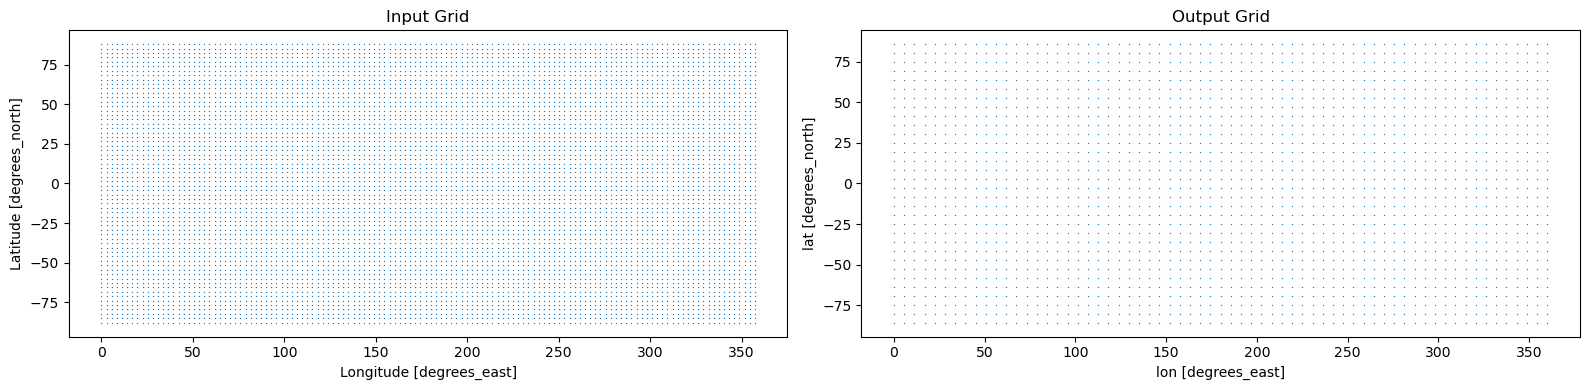

In [4]:
output_grid = xcdat.create_gaussian_grid(32)

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.regridder.grid.plot.scatter(x="lon", y="lat", s=4, ax=axes[0])
axes[0].set_title("Input Grid")

output_grid.plot.scatter(x="lon", y="lat", s=4, ax=axes[1])
axes[1].set_title("Output Grid")

plt.tight_layout()

## 3. Regrid the data

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

Here we will regrid the input data to the ouptut grid using the `xESMF` tool and the `bilinear` method.


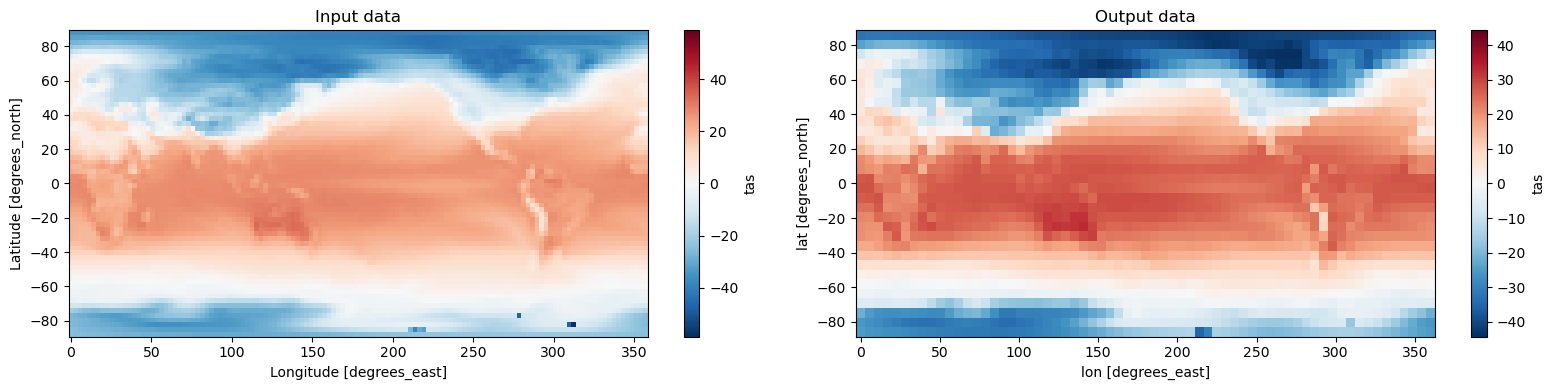

In [5]:
output = ds.regridder.horizontal("tas", output_grid, tool="xesmf", method="bilinear")

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.tas.isel(time=0).plot(ax=axes[0])
axes[0].set_title("Input data")

output.tas.isel(time=0).plot(ax=axes[1])
axes[1].set_title("Output data")

plt.tight_layout()

## 4. Regridding algorithms

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

In this example, we will compare the different regridding methods supported by `xESMF`.

You can find a more in depth comparison on `xESMF`'s [documentation](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Compare_algorithms.html).

Methods:

- bilinear
- conservative
- nearest_s2d
- nearest_d2s
- patch


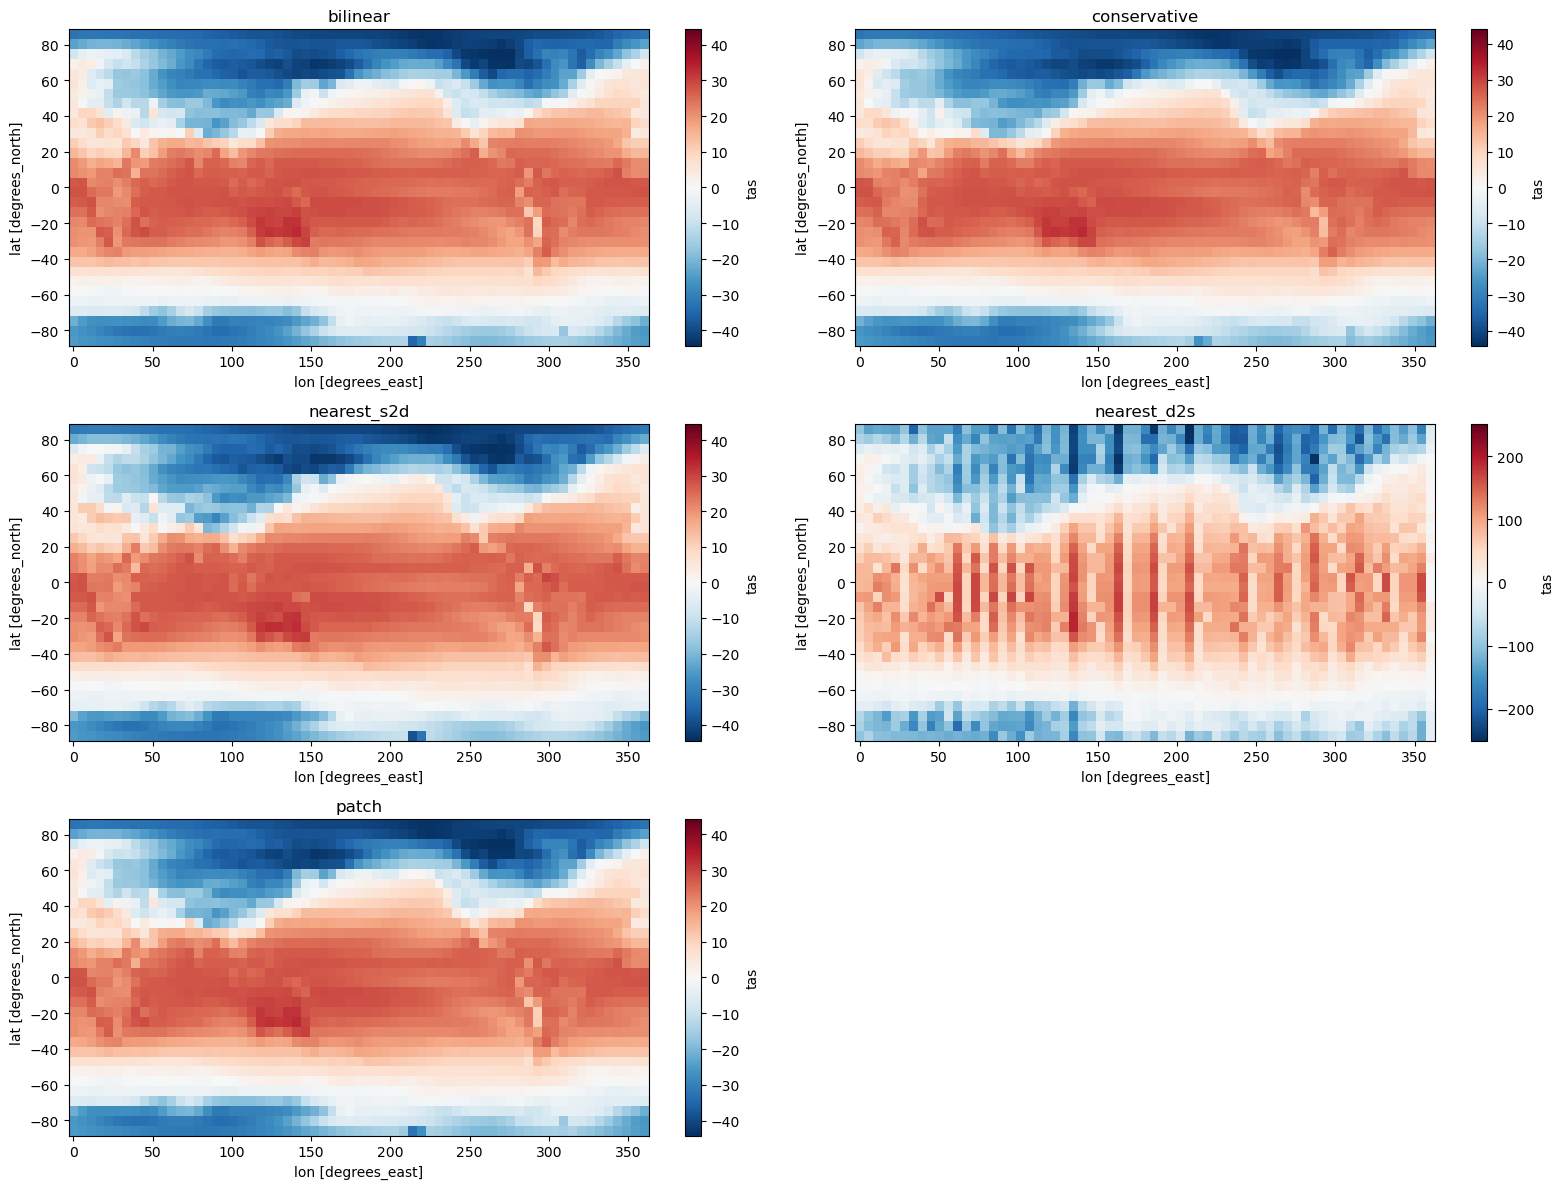

In [6]:
methods = ["bilinear", "conservative", "nearest_s2d", "nearest_d2s", "patch"]

fig, axes = plt.subplots(3, 2, figsize=(16, 12))

axes = axes.flatten()

for i, method in enumerate(methods):
    output = ds.regridder.horizontal("tas", output_grid, tool="xesmf", method=method)

    output.tas.isel(time=0).plot(ax=axes[i])

    axes[i].set_title(method)

axes[-1].set_visible(False)

plt.tight_layout()

## 5. Masking

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

`xESMF` supports masking by simply adding a data variable with the id `mask`.

See `xESMF` [documentation](https://pangeo-xesmf.readthedocs.io/en/latest/notebooks/Masking.html) for additonal details.


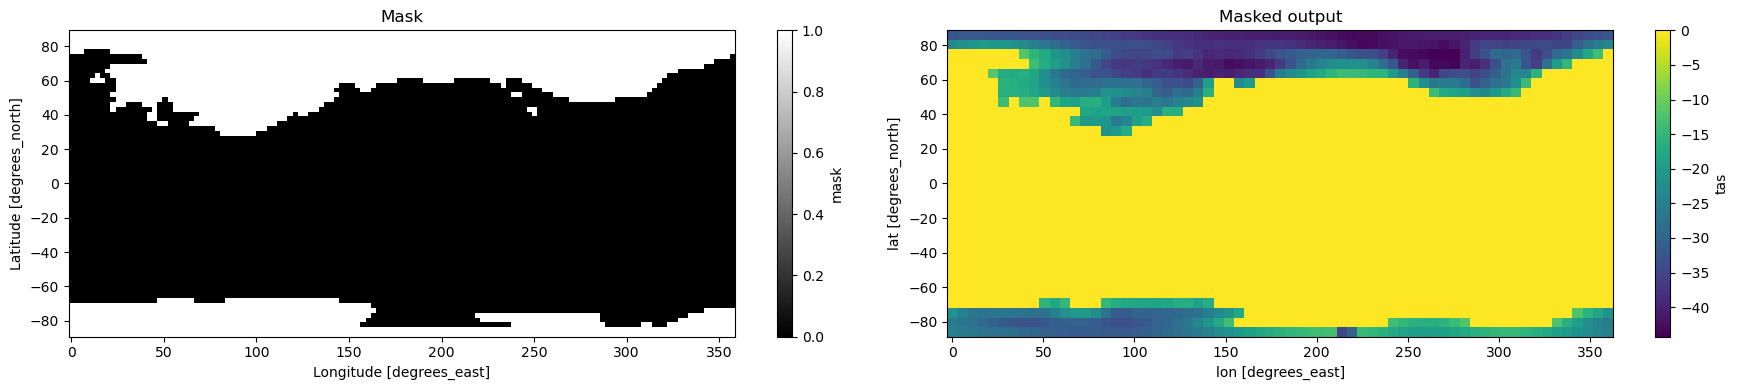

In [7]:
ds["mask"] = xr.where(ds.tas.isel(time=0) < -10, 1, 0)

masked_output = ds.regridder.horizontal(
    "tas", output_grid, tool="xesmf", method="bilinear"
)

fig, axes = plt.subplots(ncols=2, figsize=(18, 4))

ds["mask"].plot(ax=axes[0], cmap="binary_r")
axes[0].set_title("Mask")

masked_output.tas.isel(time=0).plot(ax=axes[1])
axes[1].set_title("Masked output")

plt.tight_layout()

## 6. Regridding using `regrid2`

Related API: [xarray.Dataset.regridder.horizontal()](../generated/xarray.Dataset.regridder.horizontal.rst)

`Regrid2` is a conservative regridder for rectilinear (lat/lon) grids originally from the `cdutil` package from `CDAT`.

This regridder assumes constant latitude lines when generating weights.


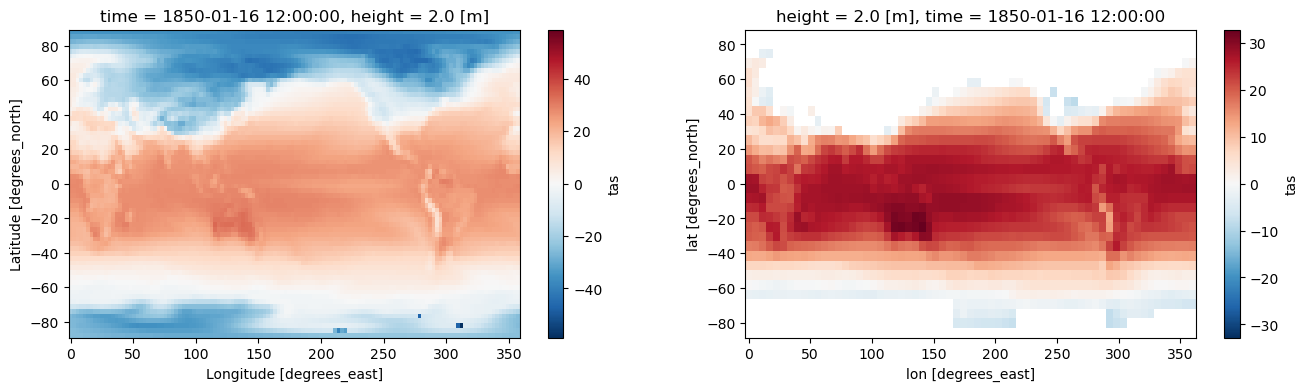

In [8]:
output = ds.regridder.horizontal("tas", output_grid, tool="regrid2")

fig, axes = plt.subplots(ncols=2, figsize=(16, 4))

ds.tas.isel(time=0).plot(ax=axes[0])

output.tas.isel(time=0).plot(ax=axes[1])